In [149]:
import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import DataLoader
import pandas as pd

In [150]:
# Read Data
spectrum_train = pd.read_excel('spectrum_train.xlsx')
spectrum_test = pd.read_excel('spectrum_valid.xlsx')
temp_train = pd.read_excel('temp_train.xlsx')
temp_test = pd.read_excel('temp_valid.xlsx')

In [151]:
spectra = spectrum_test.columns

In [152]:
def rename_columns(df):
    new_df = df
    for i in range(len(df.columns)):
        new_df.columns.values[i] = int(i)

    return new_df

In [153]:
spectrum_train_scaled = spectrum_train.multiply(10**12)
spectrum_test_scaled = spectrum_test.multiply(10**12)

In [154]:
# 1 - temp to spectrum
# 0 - spectrum to temp
direction = 1

if direction:
    X_train = temp_train
    X_test = temp_test
    y_train = spectrum_train_scaled
    y_test = spectrum_test_scaled
else:
    X_train = spectrum_train_scaled
    X_test = spectrum_test_scaled
    y_train = temp_train
    y_test = temp_test

In [155]:
# determine the supported device
def get_device():
    if torch.cuda.is_available():
        device = torch.device('cuda:0')
    else:
        device = torch.device('cpu') # don't have GPU 
    return device

# convert a df to tensor to be used in pytorch
def df_to_tensor(df):
    device = get_device()
    return torch.from_numpy(df.values).float().to(device)

In [156]:
input_data = df_to_tensor(X_train)
output_data = df_to_tensor(y_train)

In [157]:
class Net(nn.Module):
    def __init__(self, input_size, output_size):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 256)
        self.fc3 = nn.Linear(256, 512)
        self.fc4 = nn.Linear(512, 256)
        self.fc5 = nn.Linear(256, 128)
        self.fc6 = nn.Linear(128, output_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = torch.relu(self.fc5(x))
        x = self.fc6(x)
        return x

In [158]:
input_size = len(X_train.columns)
output_size = len(y_train.columns)
model = Net(input_size=input_size, output_size=output_size)

In [159]:
criterion = nn.MSELoss()  # Mean Squared Error loss for regression
optimizer = optim.Rprop(model.parameters(), lr=0.001) 

In [160]:
num_epochs = 15
batch_size = 10
num_batches = len(input_data) // batch_size

for epoch in range(num_epochs):
    for batch in range(num_batches):
        start = batch * batch_size
        end = start + batch_size

        inputs = input_data[start:end]
        targets = output_data[start:end]

        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)

        # Compute loss
        loss = criterion(outputs, targets)

        # Backpropagation and optimization
        loss.backward()
        optimizer.step()

    # Print the loss for this epoch
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.6f}")

Epoch 1/15, Loss: 3.911881
Epoch 2/15, Loss: 2.688491
Epoch 3/15, Loss: 0.553749
Epoch 4/15, Loss: 0.923024
Epoch 5/15, Loss: 0.697363
Epoch 6/15, Loss: 0.813685
Epoch 7/15, Loss: 1.026226
Epoch 8/15, Loss: 2.333361
Epoch 9/15, Loss: 0.661097
Epoch 10/15, Loss: 1.333181
Epoch 11/15, Loss: 1.314180
Epoch 12/15, Loss: 1.073016
Epoch 13/15, Loss: 1.242423
Epoch 14/15, Loss: 1.257478
Epoch 15/15, Loss: 0.660174


In [161]:
pred = model(df_to_tensor(X_test))
pred = pd.DataFrame(pred.detach().numpy())

actual = y_test

In [162]:
actual

,0.000005,0.000005,0.000005,0.000005,0.000005,0.000005,0.000005,0.000005,0.000005,0.000005,...,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008
0,2.373538,2.602481,2.775814,2.935397,3.074856,3.220465,3.363583,3.505908,3.647634,3.790090,...,10.069020,10.146292,10.208057,10.243674,10.246583,10.192531,10.036903,9.737349,9.326093,8.947765
1,2.027413,2.150030,2.250785,2.362463,2.467873,2.581041,2.694600,2.809533,2.925638,3.043688,...,8.794491,8.871859,8.934365,8.973221,8.983096,8.942860,8.813263,8.556884,8.201778,7.875021
2,2.470590,2.726463,2.921211,3.095970,3.246416,3.402639,3.555543,3.706972,3.857192,4.007671,...,10.460966,10.538142,10.599540,10.633985,10.634567,10.576088,10.412293,10.099323,9.670691,9.276407
3,1.950271,2.046041,2.131383,2.233903,2.333012,2.440313,2.548641,2.658761,2.770347,2.884035,...,8.542764,8.620148,8.682729,8.722118,8.733251,8.695631,8.571070,8.323129,7.979041,7.662406
4,2.523524,2.771409,2.957469,3.126776,3.273742,3.426844,3.576945,3.725913,3.874010,4.022686,...,10.456130,10.533535,10.595041,10.629530,10.630143,10.571716,10.408014,10.095198,9.666764,9.272662
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,2.192934,2.265018,2.342720,2.448247,2.552709,2.666823,2.782449,2.900217,3.019629,3.141284,...,9.084417,9.163255,9.226302,9.264688,9.273079,9.229759,9.094268,8.828052,8.460122,8.121585
188,2.866444,3.111950,3.310165,3.497918,3.661790,3.833240,4.001578,4.168564,4.334260,4.500144,...,11.480967,11.560216,11.621472,11.652821,11.646998,11.576596,11.391136,11.042846,10.568600,10.132440
189,2.472189,2.595338,2.710352,2.843756,2.969493,3.104773,3.240354,3.377164,3.514802,3.654108,...,10.103905,10.184319,10.247445,10.283357,10.286093,10.231598,10.075142,9.774224,9.361201,8.981250
190,2.981718,3.256156,3.477688,3.682082,3.857959,4.041007,4.220010,4.396886,4.571775,4.746312,...,11.902925,11.981761,12.042309,12.072085,12.063454,11.987999,11.793489,11.430545,10.937430,10.483950


In [163]:
pred

,0,1,2,3,4,5,6,7,8,9,...,56,57,58,59,60,61,62,63,64,65
0,10.497731,10.291594,11.044177,11.138773,11.686956,11.360908,11.835550,12.737667,12.694208,12.717582,...,23.851412,22.757982,24.131895,23.638506,24.113403,25.455637,22.294281,22.072220,23.824156,19.968224
1,9.367599,9.001143,9.807962,9.846005,10.245937,9.923441,10.224390,11.590238,11.287611,11.044012,...,20.751139,20.281313,20.973373,20.837540,21.215168,21.939013,19.173321,20.009623,20.432703,17.354361
2,10.709106,10.523192,11.208197,11.516305,11.862178,11.551724,12.066693,12.887836,12.895469,12.998930,...,24.360958,23.170534,24.629538,24.127357,24.538233,26.172752,22.799887,22.337898,24.256279,20.326302
3,9.036586,8.632936,9.389573,9.490725,9.718194,9.438068,9.639649,11.169761,10.781109,10.507524,...,19.797632,19.497070,20.048264,19.970348,20.354815,20.927656,18.196854,19.287535,19.244671,16.381603
4,10.666449,10.431618,11.192726,11.348921,11.806129,11.553548,12.040932,12.896951,12.887597,12.919871,...,24.182331,23.024248,24.485764,23.986155,24.483259,25.965500,22.640139,22.335899,24.225037,20.311602
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,8.565199,8.480218,8.874954,8.810679,9.401011,8.436377,9.149627,10.517219,10.135968,10.070736,...,19.375130,19.122156,19.344986,19.360773,19.350355,20.191814,17.631269,18.442539,18.004044,15.212640
188,10.173964,9.980214,10.457727,10.808919,11.007915,10.448973,11.060511,12.253543,12.042740,12.176482,...,22.844154,21.906563,22.967150,22.744284,22.697647,24.790873,21.011070,21.188423,21.976620,18.604946
189,9.039722,8.788353,9.291892,9.577443,9.666039,8.962641,9.544460,11.115943,10.637387,10.578164,...,19.972960,19.614883,19.975245,20.076845,19.892406,21.365913,18.045473,19.164177,18.725819,16.086309
190,10.385607,10.202878,10.617930,11.187807,11.188811,10.634340,11.286799,12.400712,12.243249,12.453029,...,23.346409,22.320053,23.442879,23.224087,23.108749,25.500711,21.513405,21.447054,22.402981,18.964184


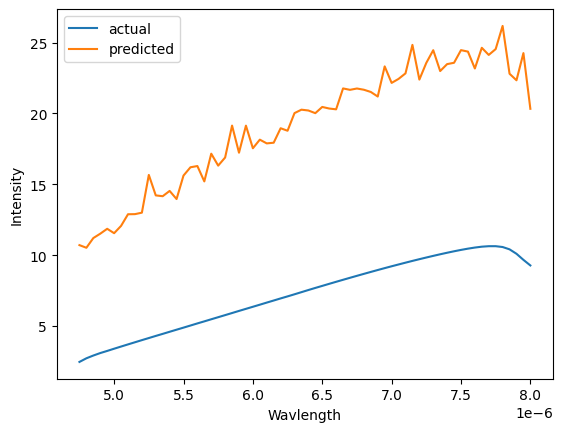

In [164]:
import matplotlib.pyplot as plt
import random

index = random.randint(0, len(actual))
plt.plot(y_train.columns, actual.values[2], label='actual')
plt.plot(y_train.columns, pred.values[2],  label='predicted')

if direction:
    plt.xlabel("Wavlength")
    plt.ylabel("Intensity")
else:
    plt.xlabel("Layer")
    plt.ylabel("Temperature (K)")

plt.legend()
plt.show()